In [16]:
import argparse
import json
import logging
import pickle
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [17]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 14,
        "figure.figsize": (10, 4.8)
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [18]:
plt.rcParamsDefault["figure.figsize"]

[6.4, 4.8]

In [19]:
api = wandb.Api(timeout=200)

In [20]:
SMOOTH_WINDOW = 10


def smooth(to_smooth, window_size=SMOOTH_WINDOW):
    smoothed = []
    for idx, val in enumerate(to_smooth):
        if idx < window_size:
            smoothed.append(np.mean(to_smooth[: idx + 1]))
        else:
            smoothed.append(np.mean(to_smooth[idx - (SMOOTH_WINDOW - 1) : idx + 1]))

    return np.array(smoothed)

In [21]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in tqdm(runs):
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                interp_y = np.interp(x_vals, h[x_key], smooth(h[y_key], 30))
            except KeyError:
                print("Could not get keys in run", r)
            else:
                env = r.config['env']
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                            relabel_dict.get("env", "env"): relabel_dict.get(
                                env, env
                            ),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

In [22]:
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "basline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'env': "Environment",
    'rollout/SuccessRate':'Average Success Rate',
    'train/std': "Action Distribution STD",
    "<SawyerPushEnvV2 instance>":"push",
    "<SawyerWindowCloseEnvV2 instance>":"window-close",
    "<SawyerDoorEnvV2 instance>":"door-open",
    "<SawyerReachEnvV2 instance>":"reach",
    "<SawyerButtonPressTopdownEnvV2 instance>":"button-press-topdown",
    "<SawyerWindowOpenEnvV2 instance>":"window-open",
    "<SawyerDrawerOpenEnvV2 instance>":"drawer-open",
    "<SawyerPegInsertionSideEnvV2 instance>":"peg-insert-side",
    "<SawyerDrawerCloseEnvV2 instance>":"drawer-close",
    "<SawyerPickPlaceEnvV2 instance>": "pick-place",
}

## Pick-Place

In [14]:
envs = ["<SawyerPushEnvV2 instance>",
"<SawyerWindowCloseEnvV2 instance>",
"<SawyerDoorEnvV2 instance>",
"<SawyerReachEnvV2 instance>",
"<SawyerButtonPressTopdownEnvV2 instance>",
"<SawyerWindowOpenEnvV2 instance>",
"<SawyerDrawerOpenEnvV2 instance>",
"<SawyerPegInsertionSideEnvV2 instance>",
"<SawyerDrawerCloseEnvV2 instance>",]
env = "PickPlace-V2"
group_and_keys = [
    ("xppo_transfer_exp", "global_step",  "rollout/SuccessRate"),
]

extra_filter = {"tags": {"$in": ['xppo_transfer_from_pick-place']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 7e6),
    extra_filter
)

Got 51 runs for group xppo_transfer_exp


 94%|█████████▍| 48/51 [00:13<00:00,  3.46it/s]

Could not get keys in run <Run resl-mixppo/stabilized-rl/2o05rejh (finished)>


100%|██████████| 51/51 [00:14<00:00,  3.54it/s]


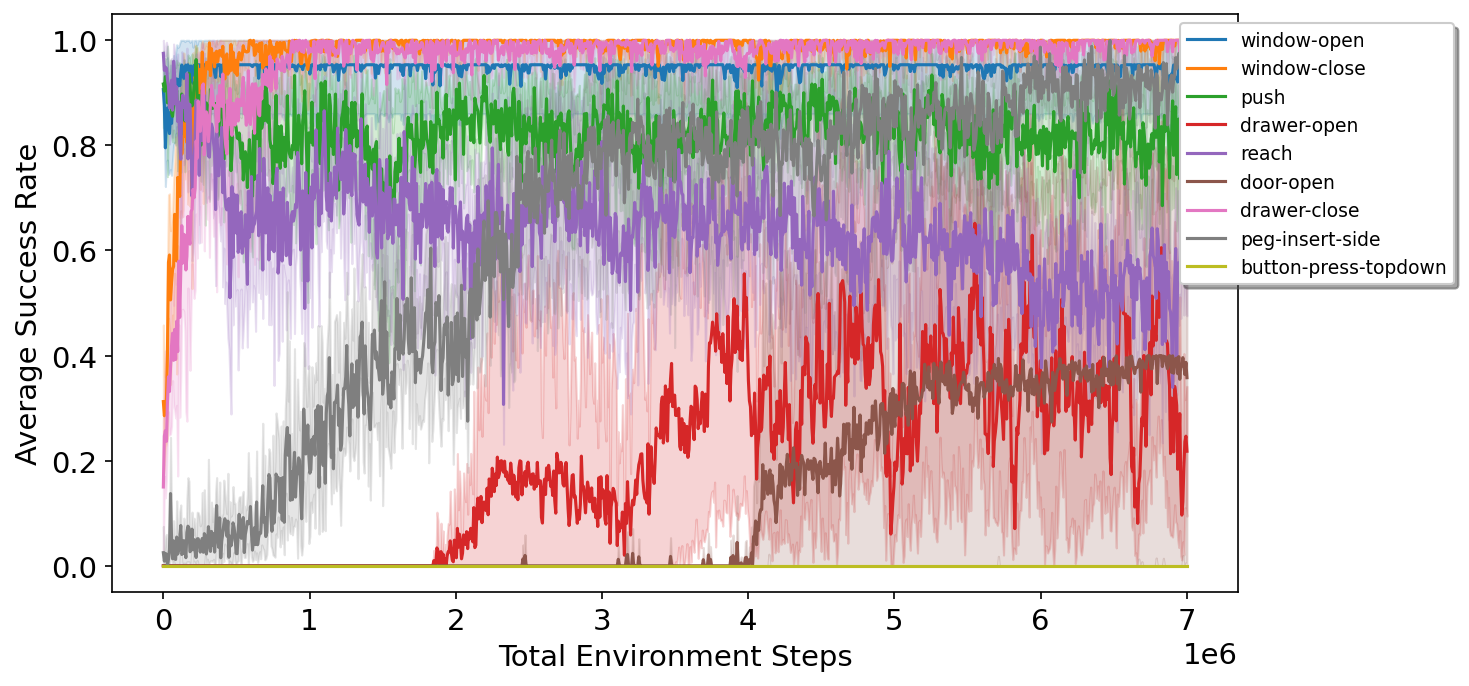

In [15]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Environment",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
# plt.legend(loc="lower right")
plt.legend(loc='upper left', bbox_to_anchor=(0.94, 1),
          ncol=1, fancybox=True, shadow=True, fontsize=9)
plt.tight_layout()
plt.savefig(f"XPPO_transfer_from_{env}.pdf")


## Window Open

In [23]:
envs = ["<SawyerPushEnvV2 instance>",
"<SawyerWindowCloseEnvV2 instance>",
"<SawyerDoorEnvV2 instance>",
"<SawyerReachEnvV2 instance>",
"<SawyerButtonPressTopdownEnvV2 instance>",
"<SawyerWindowOpenEnvV2 instance>",
"<SawyerDrawerOpenEnvV2 instance>",
"<SawyerPegInsertionSideEnvV2 instance>",
"<SawyerDrawerCloseEnvV2 instance>",]
env = "WindowOpen-V2"
group_and_keys = [
    ("xppo_transfer_exp_window_open", "global_step",  "rollout/SuccessRate"),
]

extra_filter = {"tags": {"$in": ['xppo_transfer_from_window_open']}, "$or": [{"state": "finished"}, {"state": "running"}]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 7e6),
    extra_filter
)

Got 37 runs for group xppo_transfer_exp_window_open


100%|██████████| 37/37 [00:24<00:00,  1.53it/s]


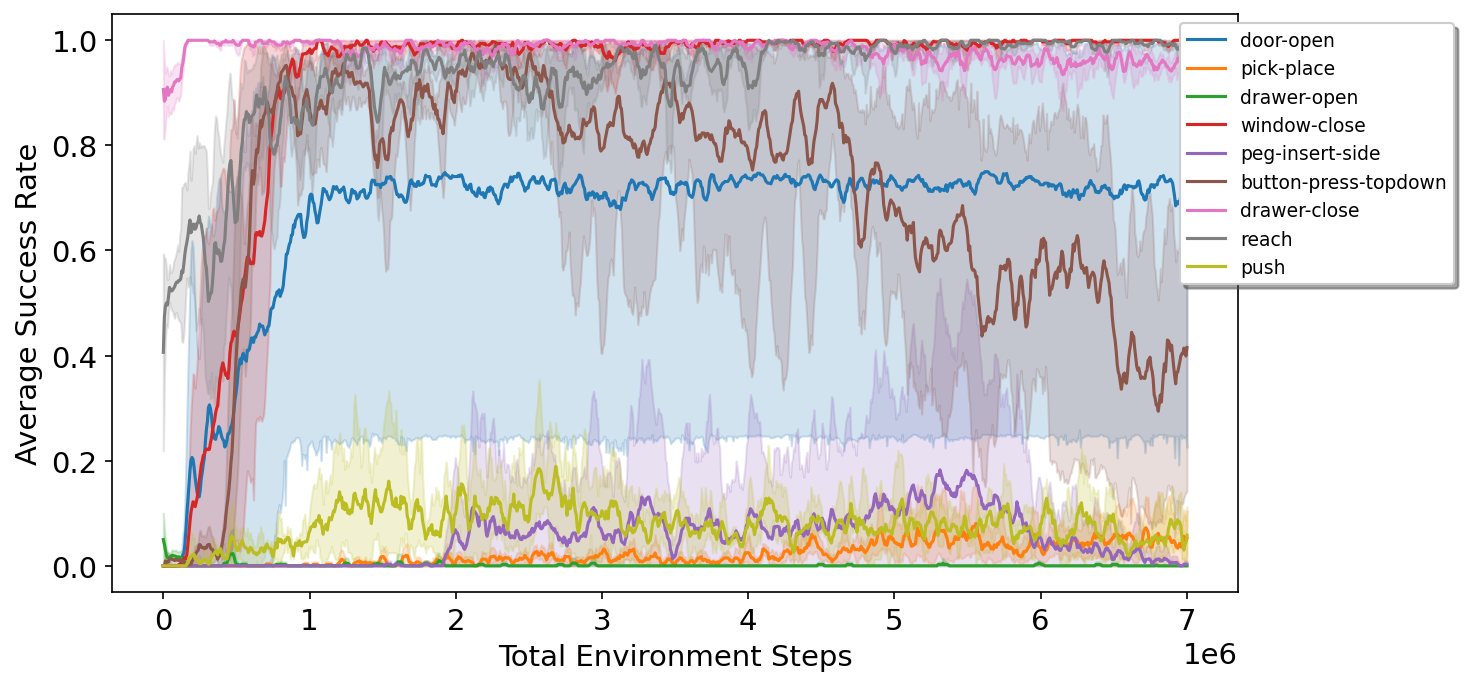

In [24]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Environment",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
# plt.legend(loc="lower right")
plt.legend(loc='upper left', bbox_to_anchor=(0.94, 1),
          ncol=1, fancybox=True, shadow=True, fontsize=9)
plt.tight_layout()
plt.savefig(f"XPPO_transfer_from_{env}.pdf")
